In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re


In [14]:
csv_dir = "/Users/reagan/Documents/GitHub/wi25-ai-team1/allStatCSVS"
team_files = [f for f in os.listdir(csv_dir) if "_Team_" in f and f.endswith(".csv")]

frames_2024, frames_2025 = [], []

def tidy_frame(path):
    df   = pd.read_csv(path)
    year = int(re.search(r"(19|20)\d{2}", path).group())          # 2024 or 2025
    stat = os.path.basename(path).split("_Team_")[0]              # e.g. "Aces_Per_Set"
    stat = stat.replace("_Per_Set", "PerSet").replace("_", "")    # cosmetic

    # rename every column *except* "Team" so it's globally unique
    df = df.rename(columns={c: f"{stat}_{c}" for c in df.columns if c != "Team"})
    df["Year"] = year
    return df[["Team", "Year", *[c for c in df.columns if c != "Team" and c != "Year"]]]

for f in team_files:
    tidy = tidy_frame(os.path.join(csv_dir, f))
    (frames_2024 if tidy["Year"].iloc[0] == 2024 else frames_2025).append(tidy)

# -- outer‑merge everything per year -------------------------------------------
from functools import reduce
master2024 = reduce(lambda l,r: pd.merge(l,r,on=["Team","Year"], how="outer"), frames_2024)
master2025 = reduce(lambda l,r: pd.merge(l,r,on=["Team","Year"], how="outer"), frames_2025)

print("2024 shape:", master2024.shape)
print("2025 shape:", master2025.shape)


2024 shape: (55, 53)
2025 shape: (64, 53)


In [19]:
#drop na rows
master2024 = master2024.dropna(subset=["MatchW-LPctg._Pct."])
master2025 = master2025.dropna(subset=["MatchW-LPctg._Pct."])

master2024.columns

Index(['Team', 'Year', 'BlocksPerSet_Rank', 'BlocksPerSet_S',
       'BlocksPerSet_W-L', 'BlocksPerSet_Block Solos',
       'BlocksPerSet_Block Assists', 'BlocksPerSet_TB', 'BlocksPerSet_Per Set',
       'DigsPerSet_Rank', 'DigsPerSet_S', 'DigsPerSet_W-L', 'DigsPerSet_Digs',
       'DigsPerSet_Per Set', 'TeamAttacksPerSet_Rank', 'TeamAttacksPerSet_S',
       'TeamAttacksPerSet_W-L', 'TeamAttacksPerSet_Kills',
       'TeamAttacksPerSet_Errors', 'TeamAttacksPerSet_Total Attacks',
       'TeamAttacksPerSet_Per Set', 'OpponentHittingPercentage_Rank',
       'OpponentHittingPercentage_S', 'OpponentHittingPercentage_W-L',
       'OpponentHittingPercentage_Opp Kills',
       'OpponentHittingPercentage_Opp Errors',
       'OpponentHittingPercentage_Opp Attacks',
       'OpponentHittingPercentage_Opp Pct', 'AssistsPerSet_Rank',
       'AssistsPerSet_S', 'AssistsPerSet_W-L', 'AssistsPerSet_Assists',
       'AssistsPerSet_Per Set', 'AcesPerSet_Rank', 'AcesPerSet_S',
       'AcesPerSet_W-L', 'Aces

In [ ]:
label = "MatchW-LPctg._Pct."

num_cols_24 = master2024.select_dtypes("number").columns
features = [c for c in num_cols_24 if c != label and c != "MatchW-LPctg._Rank" and c != "MatchW-LPctg._L" and c != "MatchW-LPctg._W"]

X_train = master2024[features]
y_train = master2024[label]

num_cols_25 = master2025.select_dtypes("number").columns
X_test = master2025[features]
y_test = master2025[label]

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

model.fit(X_train, y_train)

preds = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, preds))
print("R² :", r2_score(y_test, preds))

results = master2025[["Team", "Year"]].copy()
results["PredictedPct"] = preds
results["ActualPct"] = y_test.values
print(results.head())

MAE: 0.0314787432866938
R² : 0.9178424931020384
                         Team  Year  PredictedPct  ActualPct
0  Southern California (MPSF)  2025      0.795210      0.864
1   Long Beach St. (Big West)  2025      0.800995      0.958
2       Loyola Chicago (MIVA)  2025      0.809385      0.913
3      Barry (DI Independent)  2025      0.439699      0.435
4            Princeton (EIVA)  2025      0.535824      0.550


Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 600, 'subsample': 0.8}
CV MAE: 0.07163011418819427

2025 MAE: 0.08264118765382206
2025 R² : 0.623149112786705

Head of prediction table:
                          Team  Year  PredictedPct  ActualPct
0  Southern California (MPSF)  2025      0.672982      0.864
1   Long Beach St. (Big West)  2025      0.750194      0.958
2       Loyola Chicago (MIVA)  2025      0.751427      0.913
3      Barry (DI Independent)  2025      0.355102      0.435
4            Princeton (EIVA)  2025      0.539099      0.550


<Figure size 800x1000 with 0 Axes>

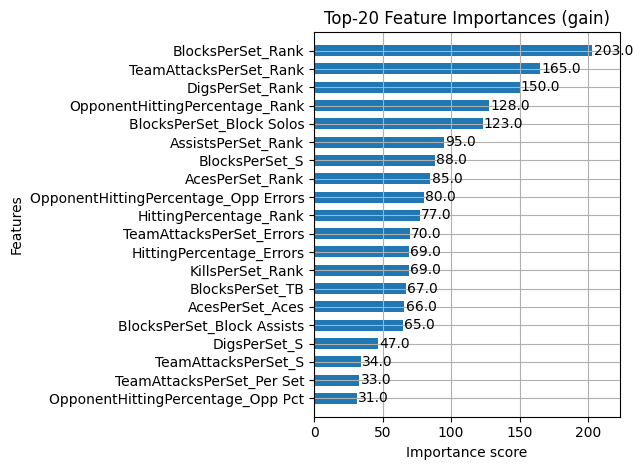

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
import matplotlib.pyplot as plt


label = "MatchW-LPctg._Pct."
features = [
    c for c in master2024.select_dtypes("number").columns
    if c != label and c != "MatchW-LPctg._Rank" and c != "MatchW-LPctg._L" and c != "MatchW-LPctg._W"
]

X_train = master2024[features]
y_train = master2024[label]

X_test  = master2025[features]
y_test  = master2025[label]


param_grid = {
    "n_estimators": [200, 400, 600],
    "max_depth":    [3, 4, 5],
    "learning_rate":[0.05, 0.1, 0.2],
    "subsample":    [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
)

cv = KFold(n_splits=10, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1,
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("CV MAE:",    -grid.best_score_)

best_model = grid.best_estimator_


preds = best_model.predict(X_test)
print("\n2025 MAE:", mean_absolute_error(y_test, preds))
print("2025 R² :",  r2_score(y_test, preds))

results = master2025[["Team", "Year"]].copy()
results["PredictedPct"] = preds
results["ActualPct"]    = y_test.values
print("\nHead of prediction table:\n", results.head())


plt.figure(figsize=(8, 10))
xgb.plot_importance(best_model, max_num_features=20, height=0.6)
plt.title("Top‑20 Feature Importances (gain)")
plt.tight_layout()
plt.show()
